## Basic COVID-19 Modelling

I recently spent a couple of days thinking about the mathematical underpinnings behind pathogenic growth, as I'm sure many other people have recently done. Despite no  research experience, I, like many others, have turned into an armchair epidemiological expert (not). As such, I thought it'd be interesting to take a mathematical, 'back-of-the-envelope' approach to modelling an outbreak, and what common-sensical factors to try and represent in my nascent model. 
 
In my mind, any model of pathogen spread, and its presupposed policy-response, must take three key concepts into account: reproduction, attempted containment, and mortality. Mounting evidence showing correlations between mortality and vaccinations with ethnicity and depravity [1] indicate that agent-based models capable of representing these heterogeneities will likely work very well in developing targeted policy-responses (such as local lockdowns). This type of model would also allow us to remove ourselves from using the imprecise 'r' concept (there are some good articles expounding the myopia of 'r'-based policy coordination). However, as someone with very little experience and even less compute at my disposal, constructing a simpler model will be my task instead.

Pathogenic replication, fission, [3], and aerosol contagion [4] boil down into an ‘R0’, denoting the mean number of new infections from one infector in a naïve population. This factor is crucial as the intensity and nature of a policy response will depend on this rate of spread of infection. Assuming *m* days that an individual in infectious after catching the illness, and only those currently infected can infect others, the daily rate of reproduction as a difference equation could be:

<br>

 $$q[t+1]-q[t]=\frac{R 0}{m}(q[t]-q[t-m])$$

<br>

Which will cause exponential growth in those infected. Accounting for a maximal population *PopMax* that can be infected:

<br>

$$q[t+1]-q[t]=\left(1-\frac{q[t]}{\operatorname{PopMax}}\right)\left(\frac{R 0}{m}\right)(q[t]-q[t-m])$$

<br>
 
Whereby as *q[t]*, the number of people who are/have been infected approaches the maximal population, the (1 - ...) coefficient will tend towards 0, and thus reduce the rate of infection, which will reduce the effective *r<sub>t</sub>* (the actual expected number of new cases per person infected). This captures the idea of individuals gaining antibody resistance to the new infection, and the pathogen therefore struggling to find new hosts whom to infect. <br><br>
To gain an insight into the nature of the exponentisl growth of a system such as this, we can plot some case curves for different 'R0':

In [231]:
import numpy as np
import pandas as pd
from pylab import plt, mpl
from scipy.stats import gamma 

In [186]:
def InfectionForecast(T, nTotal, R0, m, InitialCases, LockdownDate, LockdownIntensity):
    """
    Implements the difference equation modelling an outbreak as described above. 
    
    Arguments:
        T - Integer value denoting the total amount of time that the model will be run over
        nTotal - Integer value denoting the maximal population that can be infected
        R0 - Float denoting the 'R0' as described above
        InitialCases - Integer, should be obvious
        m - Float denoting the number of days someone is infectious for
        LockdownDate - Integer where 0 <= LDD <= T, whereby a 'lockdown' containment measure is enforced
        LockdownIntensity - Float denoting the proportion of people still part of the effective infectious population once a lockdown is implemented
    """
    
    #Initialising arrays, with one column representing the time period, and the other representing the number of cases / total cases
    
    R = float(R0)
    TotalCaseArray = np.zeros((T));
    CurrentCaseArray = np.zeros((T));
    TotalCaseArray[0] = InitialCases;
    CurrentCaseArray[0] = InitialCases;
    
    #For loop over the total number of time periods as parameterised
    for t in range(1, T):
        
        #Determine if the maximal population is either normal (nTotal), or lowered through a lockdown
        if t < LockdownDate:
            MaximalPopulation = nTotal
        else:
            MaximalPopulation = nTotal * LockdownIntensity
            
        #During the first m days of the model, the number of infectious people will simply be q[t], since q[t-m]'s index will be negative and thus not defined 
        if t < m:
            CurrentCases = TotalCaseArray[t-1]
        else:
            CurrentCases = TotalCaseArray[t-1] - TotalCaseArray[t - m - 1]

            
        #Append the total number of cases 
        TotalCaseArray[t] = TotalCaseArray[t-1] + (1 - (TotalCaseArray[t-1] / MaximalPopulation)) * (R / m) * CurrentCases
        
        #Append the current cases array
        CurrentCaseArray[t] = CurrentCases
        
        #Print when the total number of cases gets to 0, but only for the first time this happens
        if round(CurrentCaseArray[t]) == 0 and round(CurrentCaseArray[t-1]) > 0:
            print(f"No cases at time = {t-1}")
    
    return TotalCaseArray, CurrentCaseArray

No cases at time = 208
No cases at time = 142


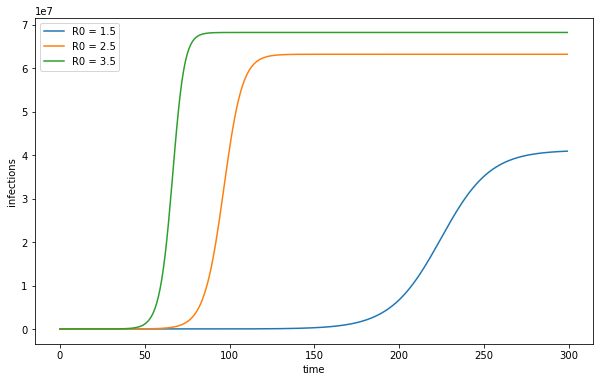

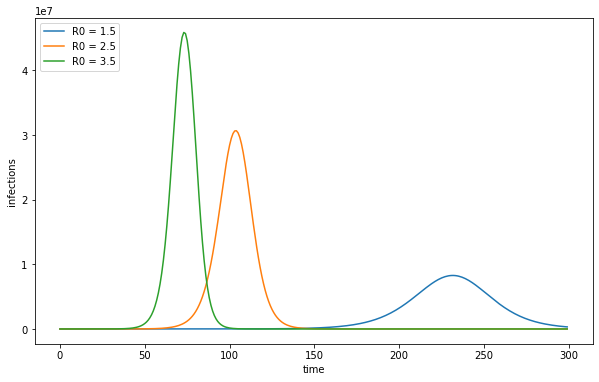

In [229]:
infectionarrayR15, casearrayR15 = InfectionForecast(300, 70000000, 1.5, 12, 5, 100, 1)
infectionarrayR25, casearrayR25 = InfectionForecast(300, 70000000, 2.5, 12, 5, 100, 1)
infectionarrayR35, casearrayR35 = InfectionForecast(300, 70000000, 3.5, 12, 5, 100, 1)
plt.figure(figsize=(10,6))
plt.plot(infectionarrayR15, lw =1.5, label = "R0 = 1.5")
plt.plot(infectionarrayR25, lw =1.5, label = "R0 = 2.5")
plt.plot(infectionarrayR35, lw =1.5, label = "R0 = 3.5")
plt.xlabel('time');
plt.ylabel('infections');
plt.legend(loc="upper left")
plt.figure(figsize=(10,6))
plt.plot(casearrayR15, lw =1.5, label = "R0 = 1.5")
plt.plot(casearrayR25, lw =1.5, label = "R0 = 2.5")
plt.plot(casearrayR35, lw =1.5, label = "R0 = 3.5")
plt.xlabel('time');
plt.ylabel('infections');
plt.legend(loc="upper left")

We note how voraciously pathogens with high ‘R0’s can spread, showing how important capturing this feature is when modelling. For lower ‘R0’, we note slower exponential growth, and a struggle to find new hosts at a rate fast enough to outpace the recovery-rate. This also indicates the total infections are proportional to the ‘R0’, but hinge on the assumption that those infected become immune to subsequent infections, thus precluding any mutative reinfection. 
<br>
We can investigate the impact of a ‘lockdown’ containment response or a vaccine rollout by reducing the PopMax parameter, as the available host population is shrunk through either physical shielding or artificial immunity. Assuming a lockdown effectiveness of 90% (which we will assume shrinks PopMax by 90%, though we can make this any proportion up to 100% [5])

No cases at time = 182
No cases at time = 125


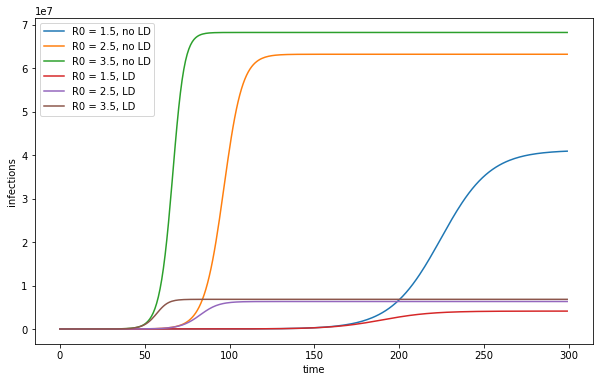

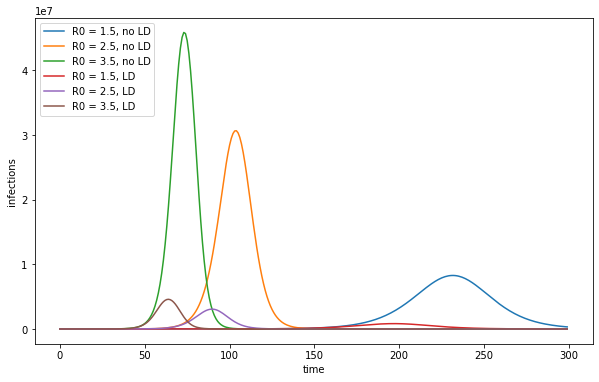

In [277]:
infectionarrayR15LD, casearrayR15LD = InfectionForecast(300, 70000000, 1.5, 12, 5, 1, 0.1)
infectionarrayR25LD, casearrayR25LD = InfectionForecast(300, 70000000, 2.5, 12, 5, 1, 0.1)
infectionarrayR35LD, casearrayR35LD = InfectionForecast(300, 70000000, 3.5, 12, 5, 1, 0.1)
plt.figure(figsize=(10,6))
plt.plot(infectionarrayR15, lw =1.5, label = "R0 = 1.5, no LD")
plt.plot(infectionarrayR25, lw =1.5, label = "R0 = 2.5, no LD")
plt.plot(infectionarrayR35, lw =1.5, label = "R0 = 3.5, no LD")
plt.plot(infectionarrayR15LD, lw =1.5, label = "R0 = 1.5, LD")
plt.plot(infectionarrayR25LD, lw =1.5, label = "R0 = 2.5, LD")
plt.plot(infectionarrayR35LD, lw =1.5, label = "R0 = 3.5, LD")
plt.xlabel('time');
plt.ylabel('infections');
plt.legend(loc="upper left")
plt.figure(figsize=(10,6))
plt.plot(casearrayR15, lw =1.5, label = "R0 = 1.5, no LD")
plt.plot(casearrayR25, lw =1.5, label = "R0 = 2.5, no LD")
plt.plot(casearrayR35, lw =1.5, label = "R0 = 3.5, no LD")
plt.plot(casearrayR15LD, lw =1.5, label = "R0 = 1.5, LD")
plt.plot(casearrayR25LD, lw =1.5, label = "R0 = 2.5, LD")
plt.plot(casearrayR35LD, lw =1.5, label = "R0 = 3.5, LD")
plt.xlabel('time');
plt.ylabel('infections');
plt.legend(loc="upper left");

Which significantly reduce total infections by a factor of 10. If we assume a 3% mortality rate [6] across all infection rates (presuming the healthcare system isn’t overwhelmed), an immediate lockdown reduces mortality by a factor of 10- a huge number. 

There is also less time until the active cases reduce to 0 (and the pathogen deemed eradicated):
<br>

Days until 0 cases:

|R0 |NO LOCKDOWN| LOCKDOWN  |
|----|-----------|-----------|
|1.5|491        |423        |
|2.5|208        |182        |
|3.5|142        |125        |

By significantly reducing the effective ‘r’, lockdown containment measures are crucial in lowering the mortality-rate and the time until eradication. This means that society and the economy is immobilised for less time and can preserve significantly more life.

<br>
So what about COVID-19? What characteristics of this Coronavirus specifically present challenges for policy responses?
<br><br>
COVID-19’s characteristic of standard antiviral interferon production hugely challenges attempts at containment with maximal transmission occurring while hosts aren’t experiencing adverse symptoms [7]. This contrasts SARS in 2002, where maximal infectiousness occurred days after symptomatic onset [8]. As a result, in the absence of mandatory social-distancing, inadvertent contagion will be rife, as people simply aren’t aware they are carriers. This challenges policy responses by significantly reducing the effectiveness of legally enforced self-isolation once individuals experience symptoms. One response is the production of systematic asymptomatic viral screening, but unfortunately prove to take months before becoming operative. 

To establish the significance of COVID-19’s interferon blocking, we append our earlier model. By changing *m* to represent the natural length of illness, and *n* to denote the time until symptoms become visible: 

$$q[t+1]-q[t]=\left(1-\frac{q[t]}{PopMax}\right)\left(\frac{R 0}{m}\right)(q[t]-q[t-(m-n)])$$

Where we assume that visibly symptomatic individuals immediately self-isolate, removing them from the infectious population. We also impose variable transmissibility post-infection by modelling intra-host transmissibility as a gamma distribution (*theta*= 1, *k=0.5m* chosen for good fit on viral load data [9]) such that the effective daily r[t]:

$$r[t]=R 0 \frac{P D F[t]}{C D F[m]}$$

Which we can see below for three different R0 values:

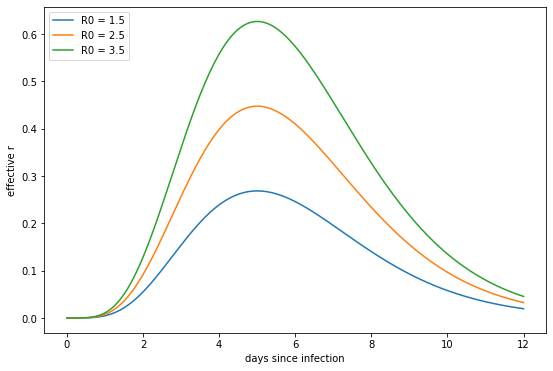

In [327]:
x = np.linspace(0, 12, 200) 
y1 = 1.5 * (gamma.pdf(x, a=6, scale=1)/gamma.cdf(12, a=6));
y2 = 2.5 * (gamma.pdf(x, a=6, scale=1)/gamma.cdf(12, a=6));
y3 = 3.5 * (gamma.pdf(x, a=6, scale=1)/gamma.cdf(12, a=6));

plt.figure(figsize=(9,6));
plt.plot(x, y1, lw =1.5, label = "R0 = 1.5");
plt.plot(x, y2, lw =1.5, label = "R0 = 2.5");
plt.plot(x, y3, lw =1.5, label = "R0 = 3.5");
plt.xlabel('days since infection');
plt.ylabel('effective r');
plt.legend(loc="upper left");

We can therefore re-specify our earlier difference equation to take into account this variable transmissibility:

$$q[t+1]-q[t]=r\left(1-\frac{q[t]}{\operatorname{PopMax}}\right) \sum_{\tau=t-n}^{t} \frac{f(t-\tau)}{F(m)}(q(\tau)-q(\tau-1))$$

$$\text { Where } f(x)=P D F \text { of Gamma Distribution }=\frac{x^{k-1} e^{-\frac{x}{\theta}}}{\Gamma(k) \theta^{k}}$$

$$\text { and } F(x)=C D F \text { of Gamma Distribution }=\frac{\gamma\left(k, \frac{x}{\theta}\right)}{\Gamma(k)}$$

Since we are specifying theta to = 1 and the python library parameterises the gamma distribution through a scale parameter (called beta), we don't need to change anything, as beta = 1/theta therefore (only in our case where theta = 1) beta == theta: true.

In [396]:
def VariableInfectionForecast(T, nTotal, R0, m, n, InitialCases, LDD, LDI):
    """
    Implements the new difference equation modelling an outbreak with variable transmission and delayed sympomatic onset. 
    
    Arguments:
        T - Integer value denoting the total amount of time that the model will be run over
        nTotal - Integer value denoting the maximal population that can be infected
        R0 - Float denoting the 'R0' as described above
        InitialCases - Integer, should be obvious
        m - Float denoting the number of days someone is infectious for
        n - Float denoting the number of days before symptoms become visible
        LDD - Integer where 0 <= LDD <= T, whereby a 'lockdown' containment measure is enforced
        LDI - Float denoting the proportion of people still part of the effective infectious population once a lockdown is implemented
    """
    
    #Initialising arrays and variables
    #NewCaseArray represents the number of new cases for each day, which we can look over to calculate how many individuals are at each stage of their transmissibility cycle
    
    NewCaseArray = np.zeros((T));
    R = float(R0)
    TotalCaseArray = np.zeros((T));
    CurrentCaseArray = np.zeros((T));
    NewCaseArray[0] = InitialCases;
    TotalCaseArray[0] = InitialCases;
    CurrentCaseArray[0] = InitialCases;
    
    #Initialise the Gamma distribution probabilities at each day within the infectious window so we don't redo calculation each time step
    GammaArrayFull=np.zeros((n));
    cdf = gamma.cdf(m, a=(0.5*m));
    for i in range(len(GammaArrayFull)):
        GammaArrayFull[i] = gamma.pdf((n-i), a=0.5*m) / cdf
        
    print(GammaArrayFull)
    
    
    #For loop over the total number of time periods as parameterised
    for t in range(1, T):
        
        #Determine if the maximal population is either normal (nTotal), or lowered through a lockdown
        if t < LDD:
            MaximalPopulation = nTotal
        else:
            MaximalPopulation = nTotal * LDI
                    
        #Ensure we aren't summing over negative index values
        if t-n < 0:
            StartDate = 0
        else:
            StartDate = t-n
        
        
        #Calculate the sum over the infectious populace at their appropriate rate of transmissibility            
        if t < n:
            DailyInfectiousness = GammaArrayFull[n-t:n];
        else:
            DailyInfectiousness = GammaArrayFull;
            
        InfectiousCases = NewCaseArray[StartDate: t];
        
        DailyInfectiousness = np.multiply(DailyInfectiousness, InfectiousCases)
        
        #Calculate the number of new cases for this time period
        NewCaseArray[t] = (1 - (TotalCaseArray[t-1] / MaximalPopulation)) * R0 * DailyInfectiousness.sum();
        
        #Append the new cases to the total # cases
        TotalCaseArray[t] = TotalCaseArray[t-1] + NewCaseArray[t];  
        
        #Print when the total number of cases gets to 0, but only for the first time this happens
        if t > 5 and round(NewCaseArray[t]) == 0 and round(NewCaseArray[t-1]) > 0:
            print(f"No cases at time = {t-1}")
        
    return TotalCaseArray, NewCaseArray;                
                                                                             

[0.01300518 0.02288063 0.03861882 0.06198777 0.09350566 0.1303685
 0.16395822 0.17911067 0.15953863 0.10291215 0.03683875 0.00312932]
No cases at time = 104
[0.06198777 0.09350566 0.1303685  0.16395822 0.17911067 0.15953863
 0.10291215 0.03683875 0.00312932]
No cases at time = 104
[0.16395822 0.17911067 0.15953863 0.10291215 0.03683875 0.00312932]
No cases at time = 127
[0.15953863 0.10291215 0.03683875 0.00312932]


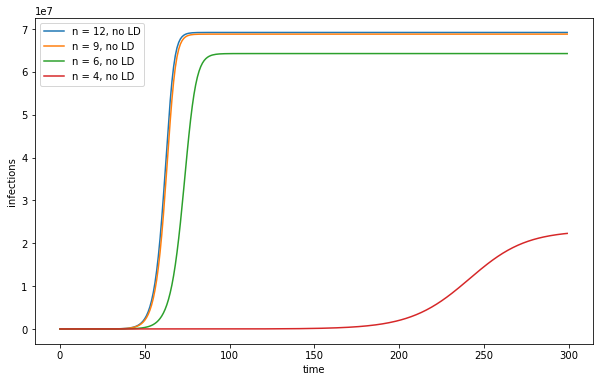

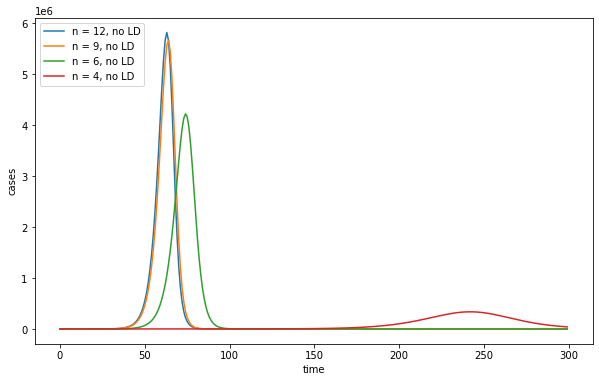

In [419]:
varinfectionarrayN12, varcasearrayN12 = VariableInfectionForecast(300, 70000000, 4, 12, 12, 5, 1, 1)
varinfectionarrayN9, varcasearrayN9 = VariableInfectionForecast(300, 70000000, 4, 12, 9, 5, 1, 1)
varinfectionarrayN6, varcasearrayN6 = VariableInfectionForecast(300, 70000000, 4, 12, 6, 5, 1, 1)
varinfectionarrayN4, varcasearrayN4 = VariableInfectionForecast(300, 70000000, 4, 12, 4, 5, 1, 1)
plt.figure(figsize=(10,6))
plt.plot(varinfectionarrayN12, lw =1.5, label = "n = 12, no LD")
plt.plot(varinfectionarrayN9, lw =1.5, label = "n = 9, no LD")
plt.plot(varinfectionarrayN6, lw =1.5, label = "n = 6, no LD")
plt.plot(varinfectionarrayN4, lw =1.5, label = "n = 4, no LD")
plt.xlabel('time');
plt.ylabel('infections');
plt.legend(loc="upper left")
plt.figure(figsize=(10,6))
plt.plot(varcasearrayN12, lw =1.5, label = "n = 12, no LD")
plt.plot(varcasearrayN9, lw =1.5, label = "n = 9, no LD")
plt.plot(varcasearrayN6, lw =1.5, label = "n = 6, no LD")
plt.plot(varcasearrayN4, lw =1.5, label = "n = 4, no LD")
plt.xlabel('time');
plt.ylabel('cases');
plt.legend(loc="upper left");

We see that time taken for symptoms to develop and thus self-isolate enormously impacts the spread and consequently mortality of the virus. Not only is the final number of cases lower, but the spread is also much slower, meaning more time for policy-responses and vaccine productions. 

References

[1] Christine Pagel, Independent Sage Presentation, 26/02/2021. https://www.youtube.com/watch?v=6YuU52uqzmM 

[2] Wilensky, U. and Rand, W., 2015. An introduction to agent-based modeling: modeling natural, social, and engineered complex systems with NetLogo. P.32-33. Mit Press.

[3] Carlson, B.M. ed., 2011. Principles of regenerative biology. Elsevier.

[4] Van Doremalen, Neeltje, et al. "Aerosol and surface stability of SARS-CoV-2 as compared with SARS-CoV-1." New England journal of medicine 382.16 (2020): 1564-1567.

[5] London Datastore, Coronavirus (COVID-19) Mobility Report, Chris Fairless, GLA Demography, https://data.london.gov.uk/dataset/coronavirus-covid-19-mobility-report 

[6] COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University. https://github.com/CSSEGISandData/COVID-19 

[7] BMJ 2020;371:m4130 http://dx.doi.org/10.1136/bmj.m4130 

[8] Kindler, E.V.F.J., Thiel, V. and Weber, F., 2016. Interaction of SARS and MERS coronaviruses with the antiviral interferon response. Advances in virus research, 96, pp.219-243.

[9] Walsh, K.A., Jordan, K., Clyne, B., Rohde, D., Drummond, L., Byrne, P., Ahern, S., Carty, P.G., O'Brien, K.K., O'Murchu, E. and O'Neill, M., 2020. SARS-CoV-2 detection, viral load and infectivity over the course of an infection: SARS-CoV-2 detection, viral load and infectivity. Journal of Infection.